# HMGCS2
[3-hydroxy-3-methylglutaryl-CoA synthase-2 deficiency (HMGCS2D)](https://omim.org/entry/605911) is caused by homozygous or compound heterozygous mutation in the HMGCS2 gene.

In [31]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.1


## HMGCS2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for HMGCS2.

In [32]:
gene_symbol = 'HMGCS2'
mane_tx_id = 'NM_005518.4'
mane_protein_id = "NP_005509.1" # hydroxymethylglutaryl-CoA synthase, mitochondrial isoform 1 precursor

In [33]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release='0.1.23') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 40/40 [00:06<00:00,  6.37individuals/s]
Validated under permissive policy
No errors or warnings were found


In [34]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
35,Hypoglycemia
30,Metabolic acidosis
29,Dicarboxylic aciduria
25,Hepatomegaly
22,Elevated circulating alanine aminotransferase concentration
20,Elevated circulating aspartate aminotransferase concentration
16,Coma
16,Seizure
14,Vomiting
12,Elevated circulating acetylcarnitine concentration


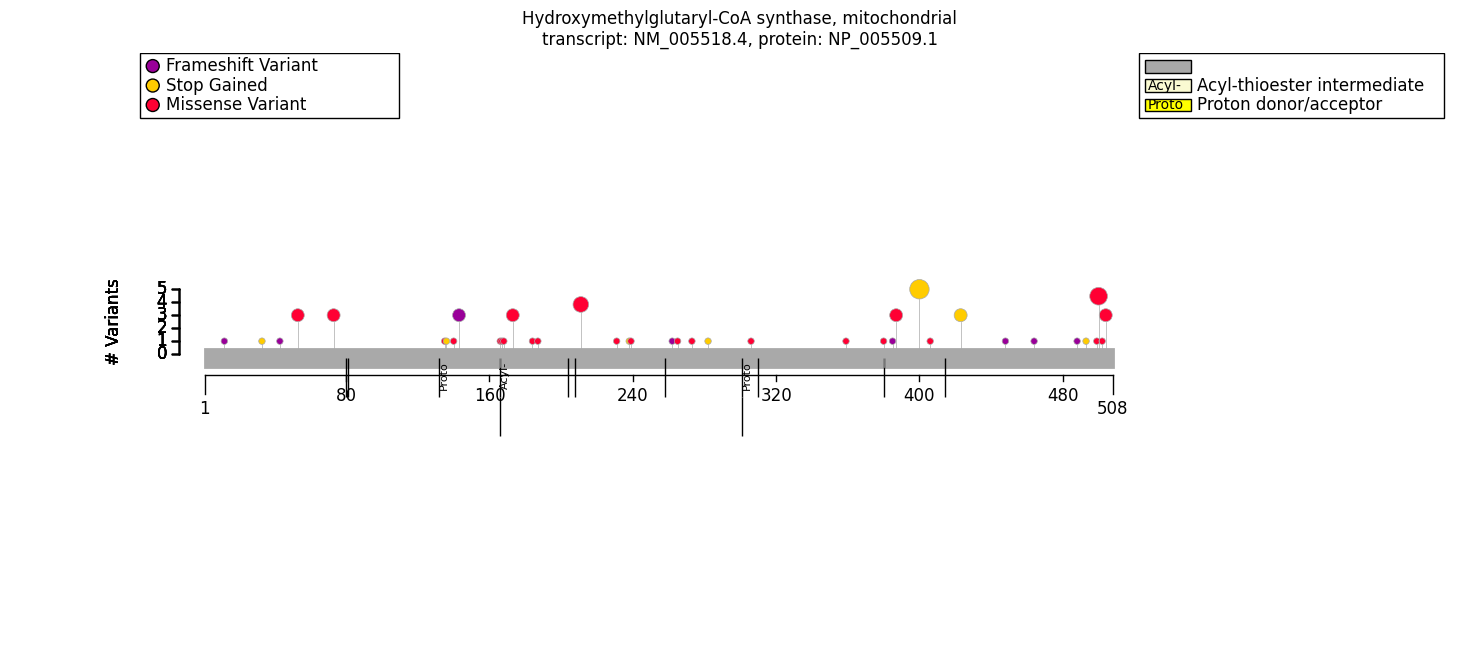

In [35]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

hmgcs2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
hmgcs2_fig.tight_layout()


In [36]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
6,SO:1000029_HGNC:5008_HMGCS2,SV involving HMGCS2 (p.?),,chromosomal deletion
5,1_119753373_119753373_C_A,c.1201G>T (p.Glu401Ter),7,stop gained
3,1_119759915_119759915_C_T,c.634G>A (p.Gly212Arg),3,missense
2,1_119764171_119764171_C_A,c.559+1G>T (-),-,splice donor
2,1_119750827_119750827_C_G,c.1502G>C (p.Arg501Pro),9,missense
2,1_119753304_119753304_G_A,c.1270C>T (p.Arg424Ter),7,stop gained
2,1_119750815_119750815_C_T,c.1514G>A (p.Arg505Gln),9,missense
2,1_119755452_119755452_C_T,c.1162G>A (p.Gly388Arg),6,missense
2,1_119764211_119764211_A_G,c.520T>C (p.Phe174Leu),2,missense
2,1_119757272_119757272_C_T,c.1016+1G>A (-),-,splice donor


# Genotype Phenotype Correlation (GPC) Analysis

In [37]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [38]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = biallelic_classifier(a_predicate=missense, 
                                   b_predicate=~missense, 
                                   a_label="missense",
                                   b_label="other",
                                    partitions=((0,1),(2,))
                                   )

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,2
HMF03,Skipping term because of a child term with the same individual counts,3
HMF08,Skipping general term,42
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,74


In [39]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/missense OR missense/other  \
                                                                                 Count   
Hepatomegaly [HP:0002240]                                                        14/17   
Vomiting [HP:0002013]                                                             8/11   
Metabolic acidosis [HP:0001942]                                                  18/20   
Elevated circulating alanine aminotransferase c...                               14/17   
Coma [HP:0001259]                                                                12/16   
Seizure [HP:0001250]                                                             12/17   
Reduced consciousness [HP:0004372]                                               12/12   
Hypoglycemia [HP:0001943]                                                        23/26   
Abnormal blood glucose concentration [HP:0011015]                                23/23   
Acidosis [HP:0001941]                                                            18/18   
Abnormal liver morphology [HP:0410042]                                           14/14   
Visceromegaly [HP:0003271]                                                       14/14   
Elevated circulating aspartate aminotransferase...                               13/15   
Elevated circulating hepatic transaminase conce...                               15/16   
Abnormal circulating hepatic transaminase conce...                               15/15   
Dicarboxylic aciduria [HP:0003215]                                               19/20   
Elevated urinary carboxylic acid [HP:0040156]                                    19/19   
Abnormal circulating fatty-acid concentration [...                               14/14   
Abnormal circulating lipid concentration [HP:00...                               15/15   

Allele group                                               other/other  \
                                                   Percent       Count   
Hepatomegaly [HP:0002240]                              82%       11/11   
Vomiting [HP:0002013]                                  73%         6/6   
Metabolic acidosis [HP:0001942]                        90%       12/12   
Elevated circulating alanine aminotransferase c...     82%         8/8   
Coma [HP:0001259]                                      75%         4/4   
Seizure [HP:0001250]                                   71%         4/7   
Reduced consciousness [HP:0004372]                    100%         4/4   
Hypoglycemia [HP:0001943]                              88%       12/13   
Abnormal blood glucose concentration [HP:0011015]     100%       12/12   
Acidosis [HP:0001941]                                 100%       12/12   
Abnormal liver morphology [HP:0410042]                100%       11/11   
Visceromegaly [HP:0003271]                            100%       11/11   
Elevated circulating aspartate aminotransferase...     87%         7/7   
Elevated circulating hepatic transaminase conce...     94%         8/8   
Abnormal circulating hepatic transaminase conce...    100%         8/8   
Dicarboxylic aciduria [HP:0003215]                     95%       13/13   
Elevated urinary carboxylic acid [HP:0040156]         100%       13/13   
Abnormal circulating fatty-acid concentration [...    100%       10/10   
Abnormal circulating lipid concentration [HP:00...    100%       11/11   

Allele group                                                                   \
                                                   Percent Corrected p values   
Hepatomegaly [HP:0002240]                             100%                1.0   
Vomiting [HP:0002013]                                 100%                1.0   
Metabolic acidosis [HP:0001942]                       100%                1.0   
Elevated circulating alanine aminotransferase c...    100%                1.0   
Coma [HP:0001259]                                     100%          

In [40]:
from gpsea.analysis.temporal.stats import LogRankTest
from gpsea.analysis.temporal.endpoint import disease_onset
from gpsea.analysis.temporal import SurvivalAnalysis

disease_id = "OMIM:605911"  # HMG-CoA synthase-2 deficiency	
endpoint = disease_onset(disease_id=disease_id)

survival_statistic = LogRankTest()

survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)

missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=endpoint,
)

print(f"survival analysis, disease onset, missense variant: p={missense_onset_result.pval}")

survival analysis, disease onset, missense variant: p=0.03796471921843459


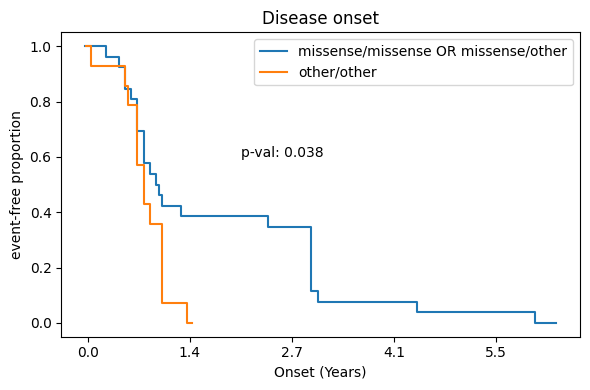

In [41]:
from matplotlib.ticker import FuncFormatter
from gpsea.model import Age

def days_to_years(x, pos):
    return f"{x / Age.DAYS_IN_YEAR:.1f}"

hmgcs2_onset_fig, ax = plt.subplots(figsize=(6, 4))
missense_onset_result.plot_kaplan_meier_curves(ax=ax)
ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))

# Add labels
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Disease onset")
ax.text(x=750, y=0.6, s=f"p-val: {missense_onset_result.pval:.3f}")

plt.tight_layout()

In [42]:
from gpsea.analysis.clf import sex_classifier


mf_fte_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_fte_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Metabolic acidosis [HP:0001942]                     12/12    100%    7/9   
Dicarboxylic aciduria [HP:0003215]                  14/14    100%  11/12   
Hepatomegaly [HP:0002240]                           11/12     92%   9/11   
Seizure [HP:0001250]                                 5/10     50%    5/8   
Hypoglycemia [HP:0001943]                           11/13     85%  11/13   
Abnormal blood glucose concentration [HP:0011015]   11/11    100%  11/11   
Acidosis [HP:0001941]                               12/12    100%    7/7   
Abnormal liver morphology [HP:0410042]              11/11    100%    9/9   
Visceromegaly [HP:0003271]                          11/11    100%    9/9   
Elevated circulating aspartate aminotransferase...  10/11     91%  10/11   
Elevated circulating hepatic transaminase conce...  12/13     92%  11/11   
Abnormal circulating hepatic transaminase conce...  12/12    100%  11/11   
Elevated circulating alanine aminotransferase c...  11/12     92%  11/13   
Elevated urinary carboxylic acid [HP:0040156]       14/14    100%  11/11   
Abnormal circulating fatty-acid concentration [...    9/9    100%    9/9   
Abnormal circulating lipid concentration [HP:00...  10/10    100%  10/10   
Vomiting [HP:0002013]                                9/11     82%    5/6   

Sex                                                                            \
                                                   Percent Corrected p values   
Metabolic acidosis [HP:0001942]                        78%                1.0   
Dicarboxylic aciduria [HP:0003215]                     92%                1.0   
Hepatomegaly [HP:0002240]                              82%                1.0   
Seizure [HP:0001250]                                   62%                1.0   
Hypoglycemia [HP:0001943]                              85%                1.0   
Abnormal blood glucose concentration [HP:0011015]     100%                1.0   
Acidosis [HP:0001941]                                 100%                1.0   
Abnormal liver morphology [HP:0410042]                100%                1.0   
Visceromegaly [HP:0003271]                            100%                1.0   
Elevated circulating aspartate aminotransferase...     91%                1.0   
Elevated circulating hepatic transaminase conce...    100%                1.0   
Abnormal circulating hepatic transaminase conce...    100%                1.0   
Elevated circulating alanine aminotransferase c...     85%                1.0   
Elevated urinary carboxylic acid [HP:0040156]         100%                1.0   
Abnormal circulating fatty-acid concentration [...    100%                1.0   
Abnormal circulating lipid concentration [HP:00...    100%                1.0   
Vomiting [HP:0002013]                                  83%                1.0   

Sex                                                           
                                                    p values  
Metabolic acidosis [HP:0001942]                     0.171429  
Dicarboxylic aciduria [HP:0003215]                  0.461538  
Hepatomegaly [HP:0002240]                           0.590062  
Seizure [HP:0001250]                                0.664061  
Hypoglycemia [HP:0001943]                           1.000000  
Abnormal blood glucose concentration [HP:0011015]   1.000000  
Acidosis [HP:0001941]                               1.000000  
Abnormal liver morphology [HP:0410042]              1.000000  
Visceromegaly [HP:0003271]                          1.000000  
Elevated circulating aspartate aminotransferase...  1.000000  
Elevated circulating hepatic transaminase conce...  1.000000  
Abnormal circulating hepatic transaminase conce...  1.000000  
Elevated circulating alanine aminotransferase c...  1.000000  
Elevated urinary carboxylic acid [HP:0040156]       1.000000  
Abnorma

# Summary

In [43]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ), GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_fte_result,
    ), 
)

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_onset_result
    ),
)

caption = "No previous publications with results on genotype-phenotype correlations in HMGCS2 were identified."

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=f_results,
    mono_results=m_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption=caption,
)

In [44]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [45]:
summarizer.process_latex(report=report, protein_fig=hmgcs2_fig, stats_fig=hmgcs2_onset_fig)

Figure saved to ../../supplement/img/HMGCS2_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/HMGCS2_stats-draft.pdf
Output to ../../supplement/tex/HMGCS2_summary_draft.tex
